In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from timeit import timeit
from tqdm import trange, tqdm

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from ensembles import RMSE, RandomForestMSE, GradientBoostingMSE

In [3]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('image', cmap='Greys', interpolation='none')
plt.rc('font', family='serif', serif=['XCharter'])
plt.rc('mathtext', fontset='dejavuserif')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')

## Загрузка данных 

In [4]:
from sklearn.model_selection import train_test_split

dir0 = '../data/'
X = pd.read_csv(dir0 + 'train_data.csv', index_col=0)
y = pd.read_csv(dir0 + 'train_target.csv', index_col=0)
X['date'] = pd.to_datetime(X['date'])
print((X['date'].diff().astype('timedelta64[D]') < 0).any())
X

False


,id,date,bedrooms_number,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,square_footage_except_basement,square_footage_only_basement,build_year,renovation_year,coordinate_latitude,coordinate_longitude,square_footage_home_old,square_footage_lot_old
index,,,,,,,,,,,,,,,,,,,
0,16530,2014-05-02,2,2.00,1350,2560,1.0,0,0,3,8,1350,0,1976,0,200.6344,4.893,1790,2560
1,3651,2014-05-02,3,1.75,1800,23103,1.0,0,0,3,7,1800,0,1968,0,200.6517,5.094,1410,18163
2,13568,2014-05-02,3,1.75,2240,10578,2.0,0,0,5,8,1550,690,1923,0,200.6954,4.708,1570,10578
3,20352,2014-05-02,4,2.00,1820,5000,1.5,0,1,3,7,1640,180,1945,0,200.6815,4.731,2060,5000
4,10524,2014-05-02,4,1.75,1560,8700,1.0,0,0,4,7,1560,0,1967,0,200.7274,4.819,2080,8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,7718,2015-03-10,4,2.50,1921,4888,2.0,0,0,3,7,1921,0,2009,0,200.2689,4.760,1921,9140
17276,4556,2015-03-10,3,2.50,1890,11036,1.0,0,0,3,8,1460,430,1973,0,200.7426,4.646,2040,7524
17277,11634,2015-03-10,3,1.00,1380,10112,1.0,0,0,4,7,940,440,1963,0,200.3196,4.649,1240,10112


Хотя нам не предоставлено описание признаков, скорее всего столбец `date` связан со временем поступления данных (даты упорядочены и «находятся там, где следует находиться подобным отметкам»). Поэтому не будем шафлить датасет при разделении на обучение и валидацию. Из самих дат возьмем номер месяца, дня в месяце и день недели.

In [5]:
features = ['dayofweek', 'day', 'month']
for feature in features:
    X[feature] = getattr(X['date'].dt, feature)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X.drop(columns='date').to_numpy(), y.to_numpy().ravel(),
    shuffle=False, test_size=0.2)

In [7]:
fit_args = {
    'X': X_train,
    'y': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'return_train_loss': True,
    'return_val_loss': True,
}

## Случайный лес
Последовательность (в скобках значение по умолчанию):
* количество деревьев (1000),
* число признаков в дереве (n / 3),
* глубина (не ограничена).

1. n_estimators
Подберем достаточное число деревьев и построим графики для качества (на обучении и на тесте) и времени (тут фит, получается). Сразу будем передавать валидацинную выборку в фит.
2. max_features
На самом деле тут немного, 21 значение. Можно перебрать по сетке [3, 5, 7, ..., 21]. Графики получатся уже не гладкие, аналогично 2.
3. max_depth
Скорее всего ограничение ничего хорошего не даст, но нужно проверить. Возьмем [2, 4, ..., 20, None]. 2 графика.

## n_estimators

In [78]:
%%time
model = RandomForestMSE(n_estimators=1000, random_state=0)
train_loss, val_loss = model.fit(**fit_args)

CPU times: user 50.8 s, sys: 7.87 ms, total: 50.8 s
Wall time: 50.8 s


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


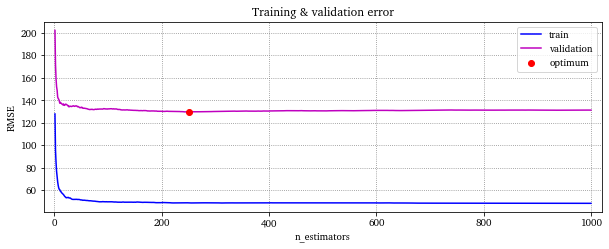

In [84]:
plt.figure(figsize=(10, 3.5))
plt.title('Training & validation error')
plt.plot(np.arange(1, 1001), train_loss, label='train', c='b')
plt.plot(np.arange(1, 1001), val_loss, label='validation', c='m')
varg = val_loss.argmin()
plt.scatter(varg + 1, val_loss[varg], c='r', zorder=3, label='optimum')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
plt.xlim((-20, 1020))
plt.savefig('vis/RF_n_estimators_RMSE')

In [94]:
n_trees = [1] + list(range(30, 301, 30))
times = []
for i in tqdm(n_trees):
    model = RandomForestMSE(n_estimators=i, random_state=0)
    times.append(timeit(lambda: model.fit(X_train, y_train), number=3) / 3)

100%|██████████| 11/11 [03:43<00:00, 20.34s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


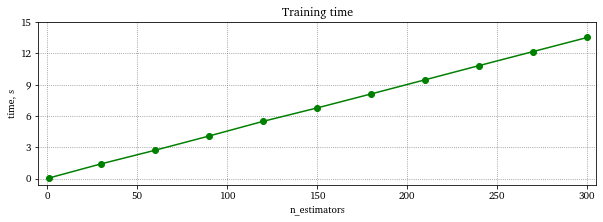

In [95]:
plt.figure(figsize=(10, 3))
plt.plot(n_trees, times, marker='o', c='green')
plt.xlim((-5, 305))
plt.xlabel('n_estimators')
plt.ylabel('time, s')
plt.yticks(np.arange(0, 17, 3))
plt.title('Training time')
plt.savefig('vis/RF_n_estimators_time')

## feature_subsample_size

In [8]:
times, loss_train, loss_val = [], [], []
max_features_grid = np.arange(X_train.shape[1]) + 1

for max_features in tqdm(max_features_grid):
    model = RandomForestMSE(n_estimators=250, random_state=0,
                            feature_subsample_size=max_features)
    times.append(timeit(lambda: model.fit(X_train, y_train), number=3) / 3)
    loss_train.append(RMSE(y_train, model.predict(X_train)))
    loss_val.append(RMSE(y_val, model.predict(X_val)))

100%|██████████| 21/21 [19:42<00:00, 56.30s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


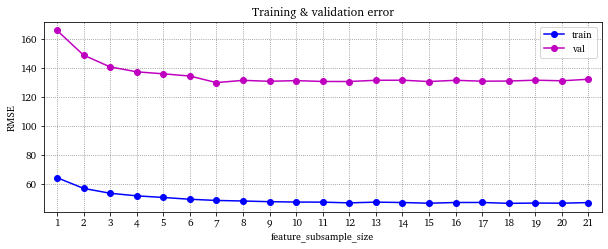

In [9]:
plt.figure(figsize=(10, 3.5))
plt.plot(max_features_grid, loss_train, label='train', c='b', marker='o')
plt.plot(max_features_grid, loss_val, label='val', c='m', marker='o')
plt.xticks(ticks=max_features_grid, labels=max_features_grid)
plt.legend()
plt.xlim((0.5, 21.5))
plt.title('Training & validation error')
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')
plt.savefig('vis/RF_max_features_RMSE')

'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


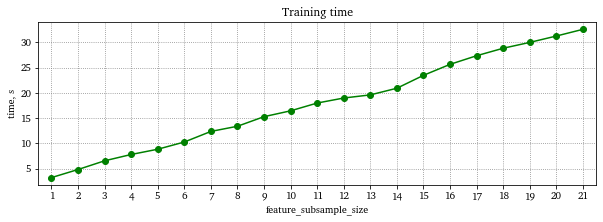

In [11]:
plt.figure(figsize=(10, 3))
plt.plot(max_features_grid, times, marker='o', c='green')
plt.xticks(ticks=max_features_grid, labels=max_features_grid)
plt.xlim((0.5, 21.5))
plt.xlabel('feature_subsample_size')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig('vis/RF_max_features_time')

## max_depth

In [24]:
times, loss_train, loss_val = [], [], []
max_depths = list(range(1, 21)) + [None]

for max_depth in tqdm(max_depths):
    model = RandomForestMSE(n_estimators=250, random_state=0,
                            feature_subsample_size=7, max_depth=max_depth)
    times.append(timeit(lambda: model.fit(X_train, y_train), number=3) / 3)
    loss_train.append(RMSE(y_train, model.predict(X_train)))
    loss_val.append(RMSE(y_val, model.predict(X_val)))

100%|██████████| 21/21 [07:43<00:00, 22.08s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


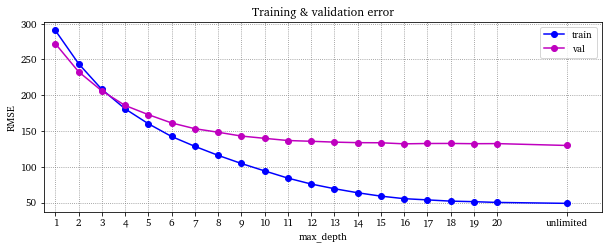

In [27]:
plt.figure(figsize=(10, 3.5))
plt.plot(max_depths[:-1]+[23], loss_train, label='train', c='b', marker='o')
plt.plot(max_depths[:-1]+[23], loss_val, label='val', c='m', marker='o')
plt.xticks(ticks=max_depths[:-1]+[23], labels=max_depths[:-1] + ['unlimited'])
plt.legend()
plt.xlim((0.5, 24.5))
plt.title('Training & validation error')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.savefig('vis/RF_max_depth_RMSE')

'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


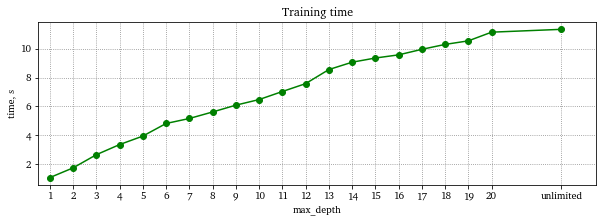

In [35]:
plt.figure(figsize=(10, 3))
plt.plot(max_depths[:-1]+[23], times, marker='o', c='green')
plt.xticks(ticks=max_depths[:-1]+[23], labels=max_depths[:-1] + ['unlimited'])
plt.xlim((0.5, 24.5))
plt.xlabel('max_depth')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig('vis/RF_max_depth_time')

## Градиентный бустинг над деревьями

Последовательность:
* количество деревьев (100),
* темп обучения (0.1), 
* глубина (5),
* число признаков в дереве (n / 3).
1. Ха-ха! Темп обучение и число деревьев, of course, будем брать вместе. Для темпа возьмем [0.01, 0.05, 0.1, 0.5, 1]. Наверное, лучше не накладывать обучение и контроль. С учетом времени, получится 3 графика.
2. Посмотрим на глубину. Здесь < 10. Можно уже совместить графики обучения и контроля.
3. Копипаста сетки с леса.

## n_estimators and learning_rate

In [36]:
lrs = [0.01, 0.05, 0.1, 0.5, 1]
train_losses = []
val_losses = []
n_trees = 2000
for lr in tqdm(lrs):
    model = GradientBoostingMSE(n_estimators=n_trees, learning_rate=lr,
                                max_depth=4, random_state=0)
    train_loss, val_loss = model.fit(**fit_args)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

100%|██████████| 5/5 [02:15<00:00, 27.10s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


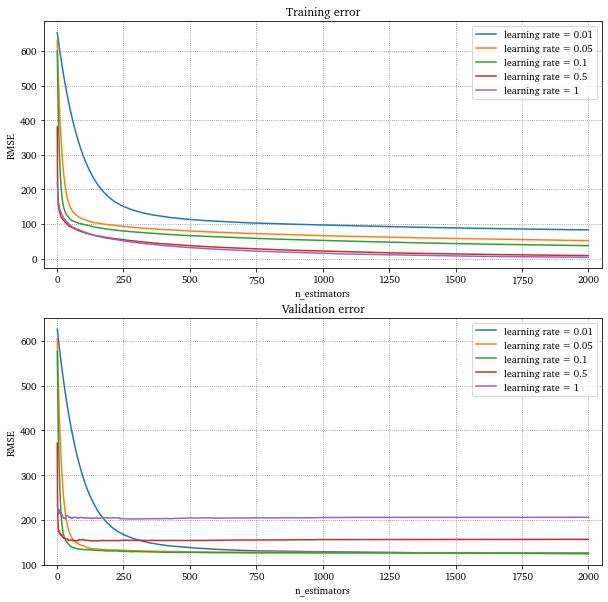

In [37]:
plt.figure(figsize=(10, 10))

plt.subplot(211)
for loss, lr in zip(train_losses, lrs):
    plt.plot(np.arange(1, n_trees+1), loss, label=f'learning rate = {lr}')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Training error')
plt.xlim(-50, 2050)

plt.subplot(212)
for loss, lr in zip(val_losses, lrs):
    plt.plot(np.arange(1, n_trees+1), loss, label=f'learning rate = {lr}')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Validation error')
plt.xlim(-50, 2050)

plt.savefig('vis/GBM_lr_RMSE')

In [39]:
n_trees = [1] + list(range(30, 301, 30))
lrs = [0.01, 0.1, 1]
times = dict(zip(lrs, [[], [], []]))
for lr in tqdm(lrs):
    for i in n_trees:
        model = GradientBoostingMSE(n_estimators=i, learning_rate=lr,
                                    max_depth=4, random_state=0)
        times[lr].append(timeit(lambda: model.fit(X_train, y_train), number=3) / 3)

100%|██████████| 3/3 [03:31<00:00, 70.48s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


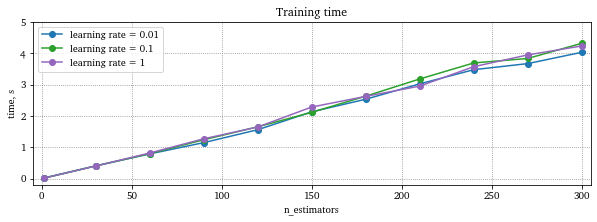

In [43]:
plt.figure(figsize=(10, 3))
default_colors = [i['color'] for i in 
                  mpl.rcParams['axes.prop_cycle'].__dict__['_left']]
for lr, c in zip(lrs, default_colors[0:5:2]):
    plt.plot(n_trees, times[lr], marker='o',
             c=c, label=f'learning rate = {lr}')
plt.legend()
plt.xlim((-5, 305))
plt.yticks(np.arange(0, 6))
plt.xlabel('n_estimators')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig('vis/GBM_lr_time')

## max_depth

In [60]:
times, loss_train, loss_val = [], [], []
max_depths = list(range(1, 11)) + [None]

for max_depth in tqdm(max_depths):
    cur_time = 0
    for i in range(3):
        model = GradientBoostingMSE(n_estimators=400, learning_rate=0.1,
                                    max_depth=max_depth, random_state=0)
        cur_time += timeit(lambda: model.fit(X_train, y_train), number=1)
    times.append(cur_time)
    loss_train.append(RMSE(y_train, model.predict(X_train)))
    loss_val.append(RMSE(y_val, model.predict(X_val)))

100%|██████████| 11/11 [04:58<00:00, 27.14s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


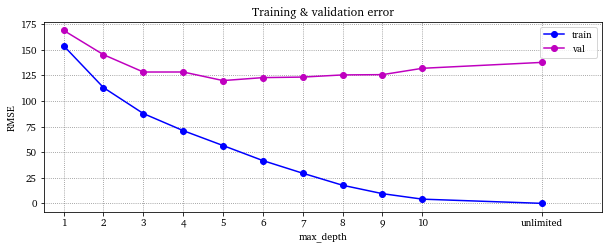

In [61]:
plt.figure(figsize=(10, 3.5))
plt.plot(max_depths[:-1]+[13], loss_train, label='train', c='b', marker='o')
plt.plot(max_depths[:-1]+[13], loss_val, label='val', c='m', marker='o')
plt.xticks(ticks=max_depths[:-1]+[13], labels=max_depths[:-1] + ['unlimited'])
plt.legend()
plt.xlim((0.5, 14.5))
plt.title('Training & validation error')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.savefig('vis/GBM_max_depth_RMSE')

'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


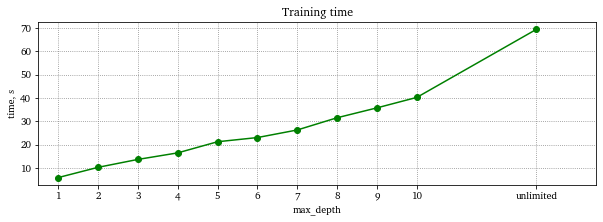

In [62]:
plt.figure(figsize=(10, 3))
plt.plot(max_depths[:-1]+[13], times, marker='o', c='green')
plt.xticks(ticks=max_depths[:-1]+[13], labels=max_depths[:-1] + ['unlimited'])
plt.xlim((0.5, 14.5))
plt.xlabel('max_depth')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig('vis/GBM_max_depth_time')

## feature_subsample_size

In [66]:
times, loss_train, loss_val = [], [], []
max_features_grid = np.arange(X_train.shape[1]) + 1

for max_features in tqdm(max_features_grid):
    cur_time = 0
    for i in range(3):
        model = GradientBoostingMSE(n_estimators=400, learning_rate=0.1,
                                    max_depth=5, random_state=0,
                                    feature_subsample_size=max_features)
        cur_time += timeit(lambda: model.fit(X_train, y_train), number=1)
    times.append(cur_time)
    loss_train.append(RMSE(y_train, model.predict(X_train)))
    loss_val.append(RMSE(y_val, model.predict(X_val)))

100%|██████████| 21/21 [10:08<00:00, 28.97s/it]


'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


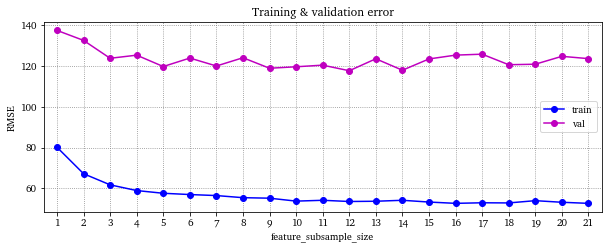

In [67]:
plt.figure(figsize=(10, 3.5))
plt.plot(max_features_grid, loss_train, label='train', c='b', marker='o')
plt.plot(max_features_grid, loss_val, label='val', c='m', marker='o')
plt.xticks(ticks=max_features_grid, labels=max_features_grid)
plt.legend()
plt.xlim((0.5, 21.5))
plt.title('Training & validation error')
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')
plt.savefig('vis/GBM_max_features_RMSE')

'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


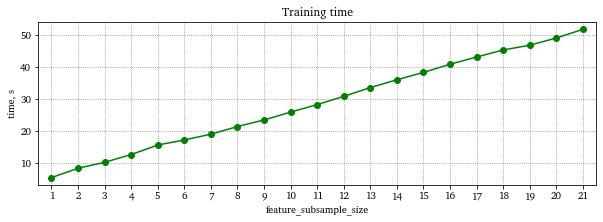

In [69]:
plt.figure(figsize=(10, 3))
plt.plot(max_features_grid, times, marker='o', c='green')
plt.xticks(ticks=max_features_grid, labels=max_features_grid)
plt.xlim((0.5, 21.5))
plt.xlabel('feature_subsample_size')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig('vis/GBM_max_features_time')

## Best fit

In [70]:
model = RandomForestMSE(n_estimators=500, random_state=0,
                        feature_subsample_size=7, max_depth=None)
train_loss_RF, val_loss_RF = model.fit(**fit_args)

In [71]:
model = GradientBoostingMSE(n_estimators=500, learning_rate=0.1,
                            max_depth=5, random_state=0,
                            feature_subsample_size=12)
train_loss_GBM, val_loss_GBM = model.fit(**fit_args)

'XCharter-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


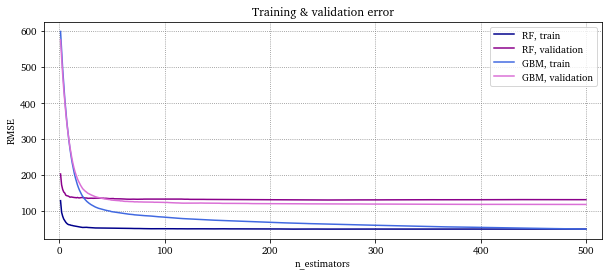

In [83]:
plt.figure(figsize=(10, 4))
losses = [train_loss_RF, val_loss_RF,
          train_loss_GBM, val_loss_GBM]
colors = ['darkblue', 'darkmagenta', 'royalblue', 'orchid']
xx = np.arange(500) + 1
names = ['RF, train', 'RF, validation', 'GBM, train', 'GBM, validation']
for loss, color, name in zip(losses, colors, names):
    plt.plot(xx, loss, color=color, label=name)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xlim(-15, 515)
plt.title('Training & validation error')
plt.savefig('vis/conclusion')

In [78]:
val_loss_RF[300], val_loss_RF[499]

(130.11910100160694, 130.71161763541895)

In [77]:
val_loss_GBM[300], val_loss_GBM[499]

(118.4080101522973, 117.40526191568054)